In [30]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from PIL import Image, ImageEnhance
import cv2

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [31]:
# importing dataset
DATADIR = "/kaggle/input/acrima-8020/db/Training"
CATEGORIES = ["Normal", "Glaucomatous"]

IMG_SIZE = 256

training_data = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
                img_array = cv2.imread(os.path.join(path, img), cv2.COLOR_RGB2BGR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])

create_training_data()

random.seed(1)

shuffle(training_data, random_state=random.randint(1, 100))

random.seed(1)

# data augmentation
data_augmentation = Sequential([
    RandomFlip(mode="horizontal_and_vertical", seed=random.randint(1, 100)),
    RandomRotation(factor=0.1, seed=random.randint(1, 100)), # ±10deg
    RandomContrast(factor=0.1, seed=random.randint(1, 100)),
    RandomTranslation(height_factor=.15, width_factor=.15, fill_mode='wrap', seed=random.randint(1, 100))
])


def he(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    channels = cv2.split(ycrcb)
    cv2.equalizeHist(channels[0], channels[0])
    cv2.merge(channels, ycrcb)
    cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR, img)
    return img


def clahe(features):
    lab_planes = list(cv2.split(cv2.cvtColor(features, cv2.COLOR_BGR2LAB)))
    clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    features = cv2.cvtColor(cv2.merge(lab_planes), cv2.COLOR_LAB2BGR)
    return features


X = []
y = []

for features, label in training_data:
    features = he(features)
    X.append(features)
    y.append(label)

N = len(X)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

100%|██████████| 316/316 [00:02<00:00, 139.11it/s]


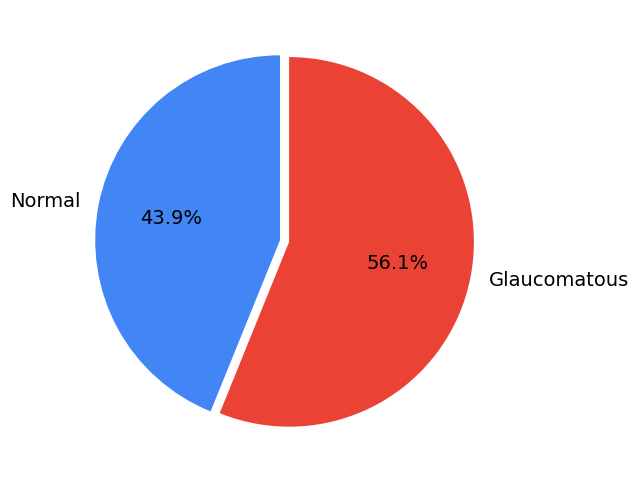

In [32]:
# plotting training dataset
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335']
plt.rcParams.update({'font.size': 14})
plt.pie([list(y).count(0), list(y).count(1)],
        labels=CATEGORIES,
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025),
        startangle=90);

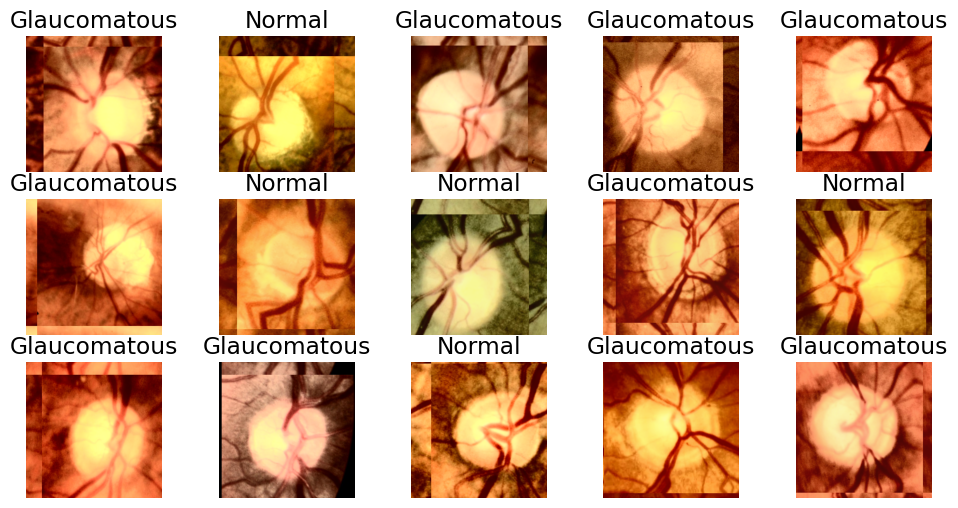

In [33]:
# plotting random images from dataset
fig = plt.figure(figsize=(12, 6))
for x in range(1, 16):
    fig.add_subplot(3, 5, x)
    plt.axis('off')
    i = random.randint(0, N-1)
    plt.title(CATEGORIES[y[i]])
    image = X[i][:, :, ::-1]/255
    image = data_augmentation(image)
    plt.imshow(image)
plt.rcParams.update({'font.size': 12})
plt.show()

In [35]:
# creating neural network model
base_model = resnet.ResNet152(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

# model.add(data_augmentation)
random.seed(1)
model.add(RandomFlip(mode="horizontal_and_vertical", seed=random.randint(1, 100)))
model.add(RandomRotation(factor=0.1, seed=random.randint(1, 100)))  # ±10deg
model.add(RandomContrast(factor=0.1, seed=random.randint(1, 100)))
model.add(RandomTranslation(height_factor=.15, width_factor=.15, fill_mode='wrap', seed=random.randint(1, 100)))

model.add(base_model)
model.add(Flatten())
model.add(Dense(IMG_SIZE, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(CATEGORIES), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [36]:
model.summary()
# keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_5 (RandomFlip)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_5               │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_5               │ (None, 256, 256, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_5            │ (None, 256, 256, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152 (Functional)          │ (None, 8, 8, 2048)     │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,926,146 (350.67 MB)

 Trainable params: 34,609,922 (132.03 MB)

 Non-trainable params: 57,316,224 (218.64 MB)

In [37]:
# training the model
batch_size = 32
epochs = 128
history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.15)

Epoch 1/128
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 839ms/step - accuracy: 0.6487 - loss: 2.7663 - val_accuracy: 0.5412 - val_loss: 2.2215
Epoch 2/128
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.7875 - loss: 0.8046 - val_accuracy: 0.5529 - val_loss: 1.4846
Epoch 3/128
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - accuracy: 0.8588 - loss: 0.4680 - val_accuracy: 0.8471 - val_loss: 0.3317
Epoch 4/128
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - accuracy: 0.8762 - loss: 0.2962 - val_accuracy: 0.6471 - val_loss: 0.8701
Epoch 5/128
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.8397 - loss: 0.3662 - val_accuracy: 0.8235 - val_loss: 0.3315
Epoch 6/128
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.8598 - loss: 0.3082 - val_accuracy: 0.9529 - val_loss: 0.1307
Epoch 7/128
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - accuracy: 0.8878 - loss: 0.2574 - val_accuracy: 0.8353 - val_loss: 0.3631
Epoch 8/128
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.8939 - loss: 0.2446 - val_acc

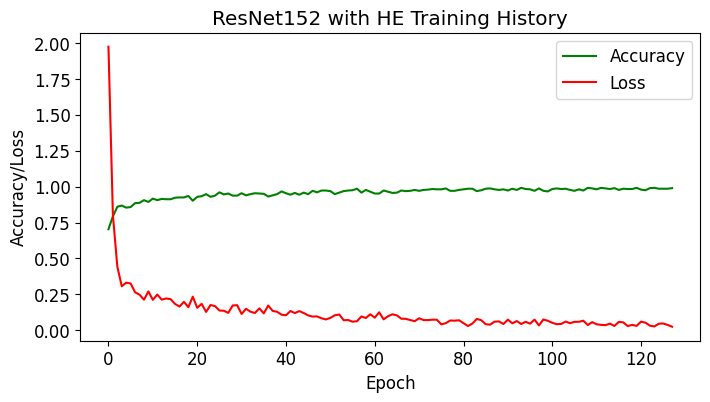

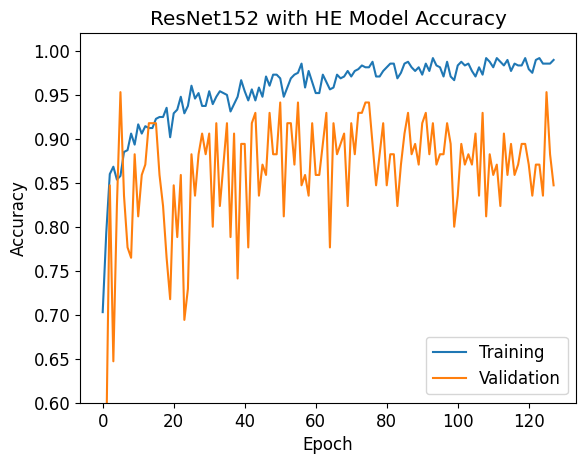

In [38]:
# plotting training history
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], 'g-')
plt.plot(history.history['loss'], 'r-')
plt.title('ResNet152 with HE Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend(['Accuracy', 'Loss'], loc='upper right')
plt.savefig('training_history', dpi=300)
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet152 with HE Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('model_accuracy', dpi=300)
ax = plt.gca()
ax.set_ylim([.6, 1.02])
plt.show()

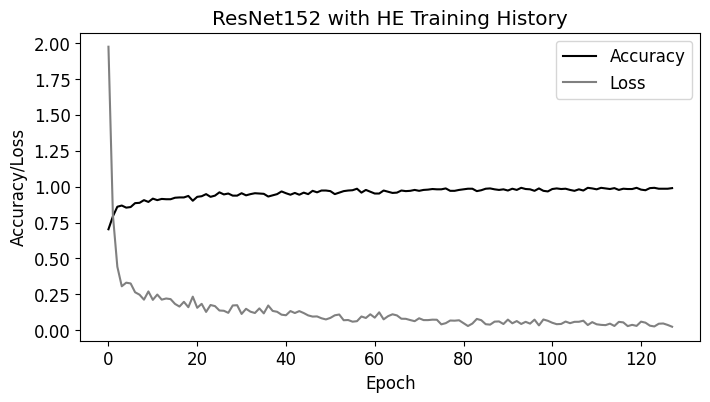

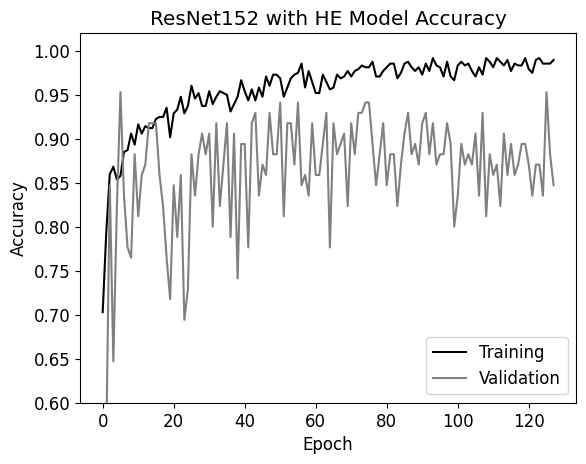

In [39]:
# plotting training history
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], 'k-')
plt.plot(history.history['loss'], '-', color='gray')
plt.title('ResNet152 with HE Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend(['Accuracy', 'Loss'], loc='upper right')
plt.savefig('training_history.jpg', dpi=300)
plt.show()

plt.plot(history.history['accuracy'], 'k-')
plt.plot(history.history['val_accuracy'], '-', color='gray')
plt.title('ResNet152 with HE Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('model_accuracy.jpg', dpi=300)
ax = plt.gca()
ax.set_ylim([.6, 1.02])
plt.show()

In [40]:
# importing dataset
TESTING_DATADIR = "/kaggle/input/acrima-8020/db/Testing"

testing_data = []

def create_testing_data():
    for category in CATEGORIES:

        path = os.path.join(TESTING_DATADIR, category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
                img_array = cv2.imread(os.path.join(path, img), cv2.COLOR_RGB2BGR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                testing_data.append([new_array, class_num])

create_testing_data()

testX = []
testy = []

for features, label in testing_data:
    features = he(features)
    testX.append(features)
    testy.append(label)

testX = np.array(testX).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
testy = np.array(testy)

100%|██████████| 80/80 [00:00<00:00, 143.23it/s]


In [41]:
y_pred = []
y_true = testy

probas = model.predict(testX)
y_pred = np.argmax(probas, axis=-1)

print(classification_report(y_true, y_pred, target_names=CATEGORIES))

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step 
              precision    recall  f1-score   support

      Normal       0.90      0.97      0.93        62
Glaucomatous       0.97      0.91      0.94        80

    accuracy                           0.94       142
   macro avg       0.93      0.94      0.94       142
weighted avg       0.94      0.94      0.94       142



Accuracy: 0.9366197183098591
Sensitivity, Recall, True Positive Rate: 0.9125
Specificity, Selectivity, True Negative Rate: 0.967741935483871
Precision, Positive Predictive Value: 0.9733333333333334
Negative Predictive Value: 0.8955223880597015
Dice Similarity Coefficient, F1 Score: 0.9419354838709677


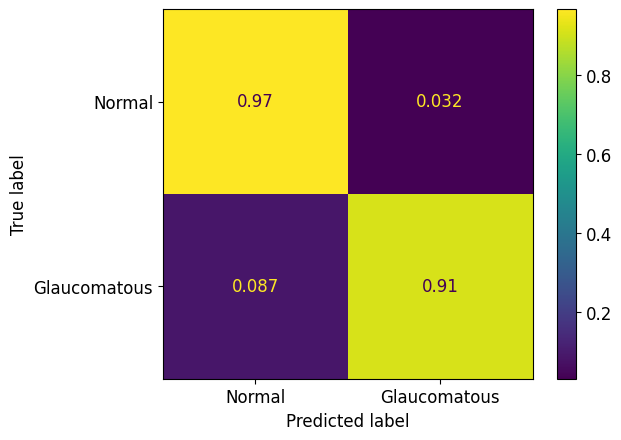

In [42]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
# positive refers to presence of glaucoma, while negative refers to a normal image

sen = tp / (tp + fn)
sp = tn / (tn + fp)
acc = (tp + tn) / ( tn + fp + fn + tp)
# auc = roc_auc_score(y_true, y_pred) #  area under receiver operating characteristics curve
ppv = tp / (tp + fp)
npv = tn / (tn + fn)
dsc = 2 * tp / (2 * tp + fp + fn)

print("Accuracy:", acc)
print("Sensitivity, Recall, True Positive Rate:", sen)
print("Specificity, Selectivity, True Negative Rate:", sp)
print("Precision, Positive Predictive Value:", ppv)
print("Negative Predictive Value:", npv)
# print("Area Under the ROC Curve:", auc)
print("Dice Similarity Coefficient, F1 Score:", dsc)

cm = confusion_matrix(y_true, y_pred, normalize='all')
CATEGORIES = ["Normal", "Glaucomatous"]
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
cmd = ConfusionMatrixDisplay.from_estimator(IC, y_pred, y_true, normalize='true', display_labels=CATEGORIES)
cmd.figure_.savefig('confusion_matrix.jpg', dpi=300)

Area Under the ROC Curve: 0.9889112903225806


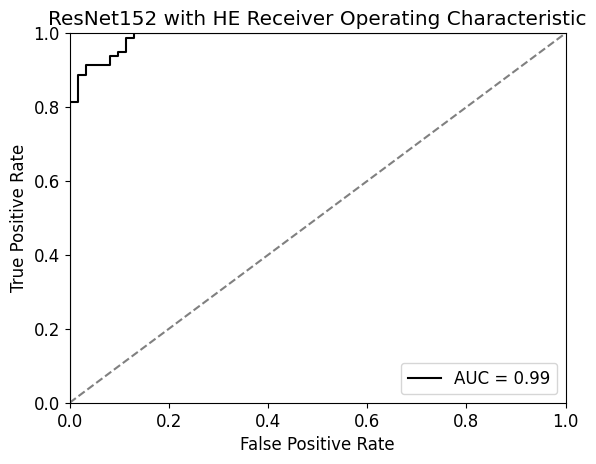

In [43]:
fpr, tpr, threshold = roc_curve(y_true, probas[:, 1])
roc_auc = auc(fpr, tpr)

print("Area Under the ROC Curve:", roc_auc)

plt.title('ResNet152 with HE Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'black', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("roc_curve.jpg", dpi=300)
plt.show()

In [44]:
print(list(y_true))
print(list(y_pred))
print(list(probas[:, 1]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[3.780885e-11, 0.00028991033, 2.190105e-10, 1.1502788e-09, 3.431126e-20, 1.7406594e-06, 3.159424e-13, 2.021936e-08, 2.6838562e-16, 4.456873e-12, 8